In [1]:
import numpy as np
import torch
import torch.nn as nn
from core import VAE,RBFNN,VAE_RBF,utils,manifolds,geodesics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'

# Download and preprocess data

In [2]:
# MNIST Dataset transformation
fashionmnist_transform = transforms.Compose([
    transforms.ToTensor(), # Converts to [0, 1] interval
    transforms.Lambda(lambda x: torch.flatten(x)) # Flattens the image to a 1D vector
])

# dataset class to efficiently extract the relevant labels and not make a copy of the entire dataset
class FilteredMNIST(Dataset):
    def __init__(self, mnist_dataset, labels):
        # Extract only the data with the specified labels
        self.data = [(img, label) for img, label in mnist_dataset if label in labels]
        self.imgs = [img for img, label in self.data]
        self.targets = [label for img, label in self.data]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# Download and load the MNIST dataset (if taking too long, cancel and try again it will worky)
full_train_dataset = datasets.FashionMNIST(root='fashionmnist_data', train=True, transform=fashionmnist_transform, download=True)
print("Original size of the dataset: ", len(full_train_dataset))
filtered_labels = [0,1,7]
print("Filtered labels: ", filtered_labels)
train_dataset = FilteredMNIST(full_train_dataset, filtered_labels)
print("New size of the dataset: ", len(train_dataset))

batch_size = 256
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,num_workers=4)

Original size of the dataset:  60000
Filtered labels:  [0, 1, 7]
New size of the dataset:  18000


# Load saved model

In [3]:
# load the saved model
input_dim = train_dataset[0][0].shape[-1]
hidden_dims = [64, 32]
latent_dim = 2
hidden_activation = nn.Tanh()
encoder_output_mu_activation=nn.Identity()
encoder_output_logvar_activation=nn.Softplus()
decoder_output_mu_activation=nn.Sigmoid()
decoder_output_logvar_activation=nn.Softplus()

model_VAE = VAE.VAE(input_dim = input_dim, 
                hidden_dims = hidden_dims,
                latent_dim = latent_dim, 
                hidden_activation=hidden_activation, 
                encoder_output_mu_activation=encoder_output_mu_activation,
                encoder_output_logvar_activation=encoder_output_logvar_activation,
                decoder_output_mu_activation=decoder_output_mu_activation,
                decoder_output_logvar_activation=decoder_output_logvar_activation)

# create RBF network
k_rbf = 64
a = 2
zeta_rbf = 1e-6
model_rbfnn = RBFNN.RBFNN(a=a,k_rbf=k_rbf,zeta_rbf=zeta_rbf,W_dim=input_dim,latent_dim=latent_dim)

# create VAE-RBF model
model_VAE_RBF = VAE_RBF.VAE_RBF(model_VAE,model_rbfnn)

model_VAE_RBF.load_state_dict(torch.load('torch_models/VAE_RBFNN_fashionmnist.pt'))

<All keys matched successfully>

# Encode and decode the whole dataset

In [4]:
# encode and decode the data and store the outputs of the model
# computed on the whole dataset
latent_means_list = []
latent_logvars_list = []
latent_z = []
output_means_list = []
output_logvars_list = []
labels_list = []

with torch.no_grad():  
    for imgs, labels_ in train_loader: 
        mu_x, log_var_x, z_enc, mu_z, log_var_z = model_VAE_RBF.VAE(imgs)
        z_rep = VAE.VAE.reparametrization_trick(mu_z, log_var_z)
        latent_means_list.append(mu_z)
        latent_logvars_list.append(log_var_z)
        latent_z.append(z_rep)
        output_means_list.append(mu_x)
        output_logvars_list.append(log_var_x)
        labels_list.append(labels_)

# Now we concatenate the list to form a single Tensor
latent_means = torch.cat(latent_means_list, dim=0)
latent_logvars = torch.cat(latent_logvars_list, dim=0)
latent_z = torch.cat(latent_z, dim=0)
output_means = torch.cat(output_means_list, dim=0)
output_logvars = torch.cat(output_logvars_list, dim=0)
labels = torch.cat(labels_list, dim=0)

# Custom implem for the manifold

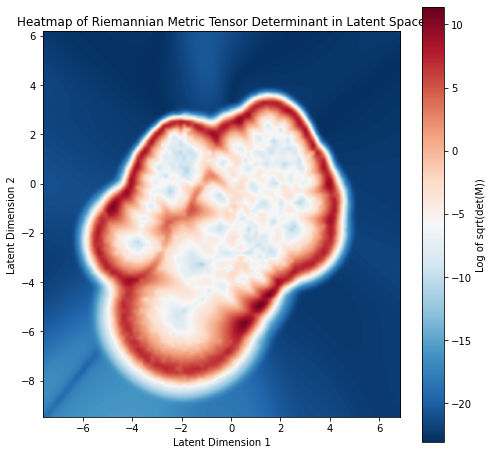

In [8]:
from core import riemannian_metric
metric = riemannian_metric.Riemannian_metric(model_VAE_RBF)
M_z = metric.compute_riemannian_metric(latent_means,var_rbfn=True)

# plot measure on latent space
latent_means_np = latent_means.detach().numpy()
z1min, z2min = latent_means_np.min(0) - 0.5
z1max, z2max = latent_means_np.max(0) + 0.5
fig, ax = plt.subplots(figsize=(8, 8))
offset=3

metric.plot_MZ(np.linspace(z1min-offset, z1max+offset, 100), np.linspace(z2min-offset, z2max+offset, 100),vae_rbfn=True)
plt.show()

In [11]:
import torch
import torch.optim as optim

#! NOT WORKING
def compute_path_energy(gamma, metric):
    N, d = gamma.shape
    M_z = metric.compute_riemannian_metric(gamma,var_rbfn=True)
    total_energy = 0.0
    dt = 1 / (N - 1)  # Assuming gamma is parameterized by t in [0, 1]

    for i in range(1, N-1):
        #dz = gamma[i] - gamma[i - 1]
        dz = (gamma[i+1] - gamma[i-1])/(2*dt)
        Mz_i = M_z[i]
        energy_i = 0.5 * torch.dot(torch.mv(Mz_i, dz), dz)*dt
        total_energy += energy_i
    return total_energy

import torch
import torch.optim as optim

def find_geodesic(x, y, N, metric, learning_rate=0.000001, epochs=1000):
    # Create a linspace for each dimension separately
    lin_spaces = [torch.linspace(x[i], y[i], steps=N) for i in range(len(x))]
    
    gamma = torch.stack(lin_spaces, dim=1)

    # Adding requires_grad=True for gradient computation
    gamma = gamma.requires_grad_(True)

    optimizer = optim.SGD([gamma], lr=learning_rate)

    paths=[]
    for epoch in range(epochs):
        if(epoch%100==0):
            print(f'Epoch {epoch}, energy: {compute_path_energy(gamma, metric)}')
            paths.append(gamma.detach().clone())
        optimizer.zero_grad()
        energy = compute_path_energy(gamma, metric)
        energy.backward()
        optimizer.step()

        # Keep endpoints fixed
        gamma.data[0] = x
        gamma.data[-1] = y

    return gamma.detach(),paths

# Example usage
x = torch.tensor([-3.5, -1.5])  # Start point
y = torch.tensor([1,-2.0])    # End point
N = 10                     # Number of points in the discretization

geodesic_path,paths = find_geodesic(x, y, N, metric)


Epoch 0, energy: 12999.2470703125
Epoch 100, energy: 374.9657897949219
Epoch 200, energy: 215.93565368652344
Epoch 300, energy: 158.33912658691406
Epoch 400, energy: 128.03233337402344
Epoch 500, energy: 109.03607177734375
Epoch 600, energy: 95.81230163574219
Epoch 700, energy: 85.96578216552734
Epoch 800, energy: 78.26705169677734
Epoch 900, energy: 72.04435729980469


In [12]:
geodesic_path

tensor([[-3.5000, -1.5000],
        [-3.2311, -1.1940],
        [-2.4446, -1.5220],
        [-1.9104, -2.1734],
        [-1.4279, -2.2654],
        [-1.0086, -1.9013],
        [-0.5166, -1.8512],
        [-0.0094, -1.8823],
        [ 0.5220, -1.9531],
        [ 1.0000, -2.0000]])

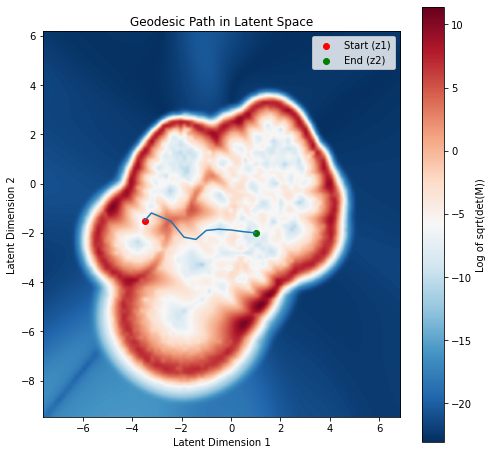

In [14]:
import matplotlib.pyplot as plt

# Convert path to numpy for plotting
#path_np = geodesic_path.detach().numpy()

# Plot the path
plt.figure(figsize=(8, 8))

offset=3
metric.plot_MZ(np.linspace(z1min-offset, z1max+offset, 100), np.linspace(z2min-offset, z2max+offset, 100),vae_rbfn=True)
# for i,path_np in enumerate(paths):
#     if(i>8):
#         random_color = np.random.rand(3,)
#         path_np = path_np.detach().numpy()
#         plt.plot(path_np[:, 0], path_np[:, 1],c=random_color)

path_np = geodesic_path.detach().numpy()
plt.plot(path_np[:, 0], path_np[:, 1])
    
plt.scatter(x[0].item(), x[1].item(), color='red', label='Start (z1)')
plt.scatter(y[0].item(), y[1].item(), color='green', label='End (z2)')

# Set labels and title
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Geodesic Path in Latent Space (NOT WORKING YET)')
plt.legend()

# Show the plot
plt.show()